___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://communist.red/wp-content/uploads/2017/08/Anarchist_flag.png" width="300px" height="180px" />


# <font color= #bbc28d> **Skip-gram & CBOW Word Embeddings** </font>
#### <font color= #2E9AFE> `Lab 2 – Text Mining`</font>
- <Strong> Sofía Maldonado, Diana Valdivia & Viviana Toledo </Strong>
- <Strong> Fecha </Strong>: 20/10/2025 

___

<p style="text-align:right;"> Imagen recuperada de: https://communist.red/wp-content/uploads/2017/08/Anarchist_flag.png</p>

In [45]:
# General Libraries
import numpy as np
import pandas as pd
import random

# Text Processing 
import re
from collections import Counter
import spacy

# Modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Evaluation
from sklearn.metrics.pairwise import cosine_similarity

#Visualization
from sklearn.manifold import TSNE
from umap import UMAP
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

# <font color= #bbc28d> **Introduction** </font>

Natural Language Processing encompasses all the tasks related to making computers understand human language, of which, word embeddings are a useful tool for achieving this goal. Word embeddings are a numerical representation of words, which allows computers to encode language into vectors which can be visualized in different dimensions.

A common representation that word embeddings use is one-hot encoding, which vectorizes each word using binary numbers in a `vector of dimensionality 1 x corpus length`, for example:  

<div style="background-color: white; text-align: center; padding: 1em; margin-bottom: 0.5em;">
<img src="https://www.baeldung.com/wp-content/ql-cache/quicklatex.com-40dd0ac8f7ba6930347fc88ac01ef5b8_l3.svg" style="display: inline-block;"/>

<div style="background-color: white; text-align: center; padding: 0.5em;">
    <img src="https://www.baeldung.com/wp-content/ql-cache/quicklatex.com-aca3b72bad8941a430b71c9946bf01b3_l3.svg" style="display: inline-block;"/>
</div>

However, such encoding can quickly scale up with large vocabularies, resulting in a curse of dimensionality. Additionally, the embeddings are susceptible to changes in the corpora size, and the vectors dont encapsulate word meaning. The one-hot encoding 'indexes' words, but is unable to capture semantic and syntantic information; the values in the vectors must somehow quantify the meaning of the words they represent.

To solve this problem, Word2Vec was introduced, a technique which generates embeddings based on word similarity, allowing them to be close to each other in a vectorized space in terms of cosine distance. There are two main algorithms to obtain a Word2Vec implementation: Continuous Bag of Words (CBOW) and Skip-Gram, which make use of neural network models.

In this notebook, we will explore both models and implement them on a corpus about Anarchy on Wikipedia.

# <font color= #bbc28d> **Preprocessing** </font>

In [9]:
# Read Wikipedia file 
with open(r"text8", "r", encoding="utf-8") as f:
    text = f.read()

The preprocessing task involves:

- Normalization of Corpus (ensuring words are in lowercase)

- Word extraction

- Tokenization by whitespace

- Remove single-letter tokens

- Select a corpus of 50,000 words

In [10]:
# Normalize data
# Convert every word to lowercase
text = text.lower()

# Keep only the words, leave the rest as whitespace
text = re.sub(r"[^a-z\s]", "", text)

# Tokenize by whitespace
tokens = text.split()

# Keep only more than single letter words
tokens = [w for w in tokens if len(w) > 1]

# Keep first 50k words
tokens_models = tokens[:50_000]

Next, we create a vocabulary from those words: 

In [11]:
# Create a vocabulary based on the clean corpora
vocab = sorted(list(set(tokens_models)))
vocab_set = set(vocab)

After creating a vocabulary, we build up a dictionary of word-index pairs for the embeddings:

In [12]:
# Create word-index dictionaries
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}

length = len(vocab)
print(f"Vocabulary Size: {length}")

Vocabulary Size: 7979


And finally, we can visualize the id of the tokens:

In [13]:
tokens_idx = [word_to_idx[w] for w in tokens_models if w in vocab_set]
tokens_idx[:10]

[362, 5086, 543, 7161, 4983, 39, 2868, 7568, 203, 2293]

# <font color= #bbc28d> **Modeling** </font>

CBOW and Skip-gram are algorithms that work on word pairs, meaning, for labeling word similarity, words are paired together and then analyzed. The pairing is done by a window-size, which selects words behind and after the target, and pairs them together. Thus, this will be the first step in our respective modelings.

Both models are going to be implemented using Pytorch, since they are, essentially, neural networks. Taking advantage of this, we will first check if cuda is available. If it is, we're going to run our models in the computer's gpu, as it speeds up training:

In [14]:
# PyTorch Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(f'Using device: {device}')

Using device: cuda


# <font color= #bbc28d> **1. Skip-Gram** </font>

The Skip-Gram algorithm tries to extract the semantics of words (context) by `predicting the context words using the main word`. By picking the word pais of the target word, each of them is run through a neural network model with one hidden layer:

<p align= "center">
    <img src='https://www.baeldung.com/wp-content/uploads/sites/4/2021/03/Baeldung-word-embeddings-1-656x1024-1.png' width="420px" height="560px">
</p>

Firstly, we need to generate the skipgram pairs. We're using a word window of 2 to 5 words:

In [15]:
def generate_skipgram_pairs(tokens_idx, min_window=2, max_window=5):
    # Guardar los pares en una lista
    pairs = []
    # Rango la longitud de el vocabulario/texto
    n = len(tokens_idx)
    for i in range(n):
        # Elegir nuestro target
        target = tokens_idx[i]
        # Ventana random entre 2 y 5
        window_size = random.randint(min_window, max_window)
        # Posiciones de inicio y fin de la window
        start = max(i - window_size, 0)
        end = min(i + window_size + 1, n)
        for j in range(start, end):
            #Skipear la target
            if j != i:
                context = tokens_idx[j]
                pairs.append((target, context))
    return pairs

skip_pairs = generate_skipgram_pairs(tokens_idx, min_window=2, max_window=5)

In [16]:
# Convert Skip-Gram pairs to text
skipgram_pairs_words = [
    (idx_to_word[target], idx_to_word[context])
    for target, context in skip_pairs
]

for i in range(5):
    print(f"Target: {skipgram_pairs_words[i][0]}  -->  Context: {skipgram_pairs_words[i][1]}")

Target: anarchism  -->  Context: originated
Target: anarchism  -->  Context: as
Target: anarchism  -->  Context: term
Target: anarchism  -->  Context: of
Target: anarchism  -->  Context: abuse


After pairing the words, we can proceed to model the data. We're using 15 epochs, a CrossEntropyLoss criterion, and an Adam optimizer with a learning rate of 0.001: 

In [17]:
# Constants
embedding_dim = 100
vocab_size = len(vocab)

# ==========================
# Model Definition
# ==========================
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output = nn.Linear(embedding_dim, vocab_size)

    def forward(self, centers):
        # centers: tensor [batch_size]
        embeds = self.embeddings(centers)  # [batch_size, emb_dim]
        out = self.output(embeds)
        return out

# ==========================
# Data Loader
# ==========================  
generator = torch.Generator(device=device)              # Set generator
# Create dataset in CPU 
skipgram_targets = torch.tensor([t for t, c in skip_pairs], dtype=torch.long)
skipgram_contexts = torch.tensor([c for t, c in skip_pairs], dtype=torch.long)
# Combine the targets and context into a list pair for training
skipgram_dataset = list(zip(skipgram_targets, skipgram_contexts))

# Data Loader for batch processing
skipgram_loader = DataLoader(skipgram_dataset, batch_size=1024, shuffle=True, generator=generator)

# ==========================
# Model Training 
# ==========================
skipgram_model = SkipGramModel(vocab_size, embedding_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(skipgram_model.parameters(), lr=0.001)
epochs = 15

for epoch in range(epochs):
    total_loss = 0
    skipgram_model.train()
    for centers, contexts in skipgram_loader:
        # Mover datos a device
        centers = centers.to(device)
        contexts = contexts.to(device)
        
        optimizer.zero_grad()
        output = skipgram_model(centers)
        loss = criterion(output, contexts)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Skip-gram Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

Skip-gram Epoch 1/15, Loss: 2879.2716
Skip-gram Epoch 2/15, Loss: 2520.3575
Skip-gram Epoch 3/15, Loss: 2359.6502
Skip-gram Epoch 4/15, Loss: 2271.4643
Skip-gram Epoch 5/15, Loss: 2213.8377
Skip-gram Epoch 6/15, Loss: 2171.0798
Skip-gram Epoch 7/15, Loss: 2136.5889
Skip-gram Epoch 8/15, Loss: 2107.2476
Skip-gram Epoch 9/15, Loss: 2081.6909
Skip-gram Epoch 10/15, Loss: 2058.9180
Skip-gram Epoch 11/15, Loss: 2038.4468
Skip-gram Epoch 12/15, Loss: 2019.8384
Skip-gram Epoch 13/15, Loss: 2002.9688
Skip-gram Epoch 14/15, Loss: 1987.4624
Skip-gram Epoch 15/15, Loss: 1973.1163


Finally, we can obtain the embeddings produced by Skip-Gram:

In [18]:
# Move embeddings to CPU for further usage (Visualization)
skipgram_embeddings = skipgram_model.embeddings.weight.data.cpu()

# Visualize the vector of a word
word = "science"
idx = word_to_idx[word]
print(f"Skip-Gram Vector of '{word}': \n {skipgram_embeddings[idx]}")

Skip-Gram Vector of 'science': 
 tensor([-0.1648, -1.6631, -2.1384, -0.3160, -0.2307, -0.5458,  1.2645,  0.4116,
        -0.6825,  0.3386, -0.3593, -1.1345,  0.3850, -0.1104,  0.5083,  1.1010,
        -1.4098,  1.7220, -0.2072, -0.3462, -0.7096, -0.2264,  0.5244,  1.2975,
        -0.7439,  1.1377, -1.2438,  1.3720, -0.1136, -0.0179, -0.6529,  0.3516,
         1.8402,  3.1711, -0.5176, -1.5837, -0.9855,  0.8389,  1.1746, -0.8493,
         1.2491, -0.9182,  0.6397,  0.8110,  0.3516,  0.4010,  1.9065,  0.6582,
        -1.9462,  0.8438,  0.1971, -0.0760,  0.2216,  1.1454, -0.6626,  0.9498,
         0.9408,  1.4773,  1.6559,  0.7074, -0.6641,  1.2880,  0.8455, -0.5203,
        -1.0990, -1.0702,  1.8234,  1.7239,  0.1291,  0.4150,  0.6344,  1.6508,
        -0.9027,  3.2198, -0.2336,  1.7649, -1.9738, -1.0455,  0.5750,  1.1491,
        -0.6029,  0.3780,  0.2422,  0.3219,  1.9544,  0.3871, -1.1750, -0.4188,
        -0.3029, -1.7101,  1.7905,  1.6613, -0.5995, -0.0207, -0.4192,  1.2154,
       

For a clearer understanding of the embeddings, let's take a look at the 10 most similar words:

In [19]:
def get_top_similar_words(embeddings, word, top_k=10):
    """
    Find top-k most similar words using cosine similarity
    """
    if word not in word_to_idx:
        print(f"Word '{word}' not in vocabulary")
        return []
    
    # Get the embedding for the anchor word
    word_idx = word_to_idx[word]
    word_embedding = embeddings[word_idx].reshape(1, -1)
    
    # Calculate cosine similarity with all other words
    similarities = cosine_similarity(word_embedding, embeddings)[0]
    
    # Get top-k most similar words (excluding the word itself)
    similar_indices = np.argsort(similarities)[::-1][1:top_k+1]  # Skip the word itself
    
    similar_words = []
    for idx in similar_indices:
        similar_words.append((idx_to_word[idx], similarities[idx]))
    
    return similar_words

# Anchor words
anchor_words = ["king", "anarchism", "communist", "revolution", "paris"] 

print(f"Skip-gram Model - Top 10 Most Similar Words related to {anchor_words}:")
print("=" * 120)
for word in anchor_words:
    similar_words = get_top_similar_words(skipgram_embeddings.numpy(), word)
    print(f"\n'{word}':")
    for similar_word, similarity in similar_words:
        print(f"  {similar_word}: {similarity:.4f}")

Skip-gram Model - Top 10 Most Similar Words related to ['king', 'anarchism', 'communist', 'revolution', 'paris']:

'king':
  let: 0.4343
  abnormally: 0.3992
  environmental: 0.3826
  relative: 0.3803
  essence: 0.3712
  john: 0.3471
  vast: 0.3454
  sexuality: 0.3448
  rivals: 0.3427
  caused: 0.3369

'anarchism':
  na: 0.3599
  criticisms: 0.3536
  formulate: 0.3512
  atrocities: 0.3508
  publicity: 0.3493
  amisus: 0.3482
  egyptian: 0.3452
  banking: 0.3438
  ideological: 0.3358
  statuette: 0.3324

'communist':
  sharp: 0.3581
  subthreshold: 0.3562
  scales: 0.3560
  milieu: 0.3485
  lanham: 0.3455
  developmental: 0.3448
  ericdigests: 0.3424
  stories: 0.3369
  italy: 0.3344
  tai: 0.3302

'revolution':
  inquiry: 0.4285
  orators: 0.3654
  alienated: 0.3636
  january: 0.3598
  swiss: 0.3511
  ireland: 0.3477
  wish: 0.3469
  synthesis: 0.3348
  editing: 0.3318
  volumes: 0.3285

'paris':
  michel: 0.3980
  van: 0.3965
  patronymic: 0.3920
  changes: 0.3644
  impairment: 0.3548

There are some words that are not exactly related to the anchor word, however, they may appear in similar contexts. Skip-Gram works best with small datasets, and since we're working with a large corpora (50,000 words) it may have some trouble identifying context. The most common associated words with our anchor words are:

- **King** <--> Battles, Hawthorne
- **Anarchism** <--> Zinovievna, Leftism
- **Communist** <--> Troilus, Revolutionary
- **Revolution** <--> Hoosier, Ukraine
- **Paris** <--> York, Hart

From this, we can see some disonances

# <font color= #bbc28d> **2. CBOW** </font>

CBOW algorithm works similar to Skip-Gram, but it does the reverse operation, the model tries to `predict the main word using the context words`. Therefore, the neural network is a mirror of Skip-gram:

<p align= "center">
    <img src='https://www.baeldung.com/wp-content/uploads/sites/4/2021/03/Screenshot-2021-03-05-at-11.29.31-1024x616-1-768x462.png' width="480px" height="360px">
</p>

Same as with Skip-Gram, we start by generating word pairs, with a window of 2 to 5 words:

In [20]:
# Generar los pares para cbow
def generate_cbow_pairs(tokens_idx, min_window=2, max_window=5):
    # Guardar los pares en una lista
    pairs = []
    # Rango la longitud de el vocabulario/texto
    n = len(tokens_idx)
    for i in range(n):
        # Elegir nuestro target
        target = tokens_idx[i]
        # Ventana random entre 2 y 5
        window_size = random.randint(min_window, max_window)
        # Posiciones de inicio y fin de la window
        start = max(i - window_size, 0)
        end = min(i + window_size + 1, n)
        # Contexto de la palabra a predecir
        context = [tokens_idx[j] for j in range(start, end) if j != i]
        if context:
            pairs.append((context, target))
    return pairs

cbow_pairs = generate_cbow_pairs(tokens_idx, min_window=2, max_window=5)

In [21]:
# Convert CBOW pairs to text
cbow_pairs_words = [
    ([idx_to_word[i] for i in context], idx_to_word[target])
    for context, target in cbow_pairs
]

for i in range(5):
    context_str = f'Context: {cbow_pairs_words[i][0]}'
    target_str = f'Target: {cbow_pairs_words[i][1]}'
    print(f"{context_str.ljust(80)}  -->  {target_str.rjust(30)}")

Context: ['originated', 'as', 'term']                                             -->               Target: anarchism
Context: ['anarchism', 'as', 'term', 'of']                                        -->              Target: originated
Context: ['anarchism', 'originated', 'term', 'of', 'abuse', 'first']              -->                      Target: as
Context: ['anarchism', 'originated', 'as', 'of', 'abuse', 'first']                -->                    Target: term
Context: ['anarchism', 'originated', 'as', 'term', 'abuse', 'first', 'used', 'against', 'early']  -->                      Target: of


After pairing the words, we can proceed to model the data. We're using 15 epochs, a CrossEntropyLoss criterion, and an Adam optimizer with a learning rate of 0.001: 

In [22]:
# ==========================
# Model Definition
# ==========================
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output = nn.Linear(embedding_dim, vocab_size)

    def forward(self, contexts):
        # contexts: lista de tensores ya en el dispositivo correcto
        embeds = [self.embeddings(c) for c in contexts]  # lista de [context_len, emb_dim]
        context_embeds = torch.stack([e.mean(dim=0) for e in embeds])  # [batch_size, emb_dim]
        out = self.output(context_embeds)
        return out
    
# ==========================
# DataLoader 
# ==========================
def cbow_collate(batch):
    contexts, targets = zip(*batch)
    # Convertir contextos a tensores y mover a device
    context_tensors = [torch.tensor(c, dtype=torch.long).to(device) for c in contexts]
    return context_tensors, torch.tensor(targets, dtype=torch.long).to(device)

cbow_loader = DataLoader(cbow_pairs, batch_size=1024, shuffle=True, collate_fn=cbow_collate, generator=generator)

# ==========================
# Model Training 
# ==========================
cbow_model = CBOWModel(vocab_size, embedding_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cbow_model.parameters(), lr=0.001)
epochs = 15

for epoch in range(epochs):
    total_loss = 0
    cbow_model.train()
    for contexts, targets in cbow_loader:
        # Los datos ya están en el dispositivo correcto gracias al collate_fn
        optimizer.zero_grad()
        output = cbow_model(contexts)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"CBOW Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

CBOW Epoch 1/15, Loss: 433.3886
CBOW Epoch 2/15, Loss: 411.1507
CBOW Epoch 3/15, Loss: 383.0992
CBOW Epoch 4/15, Loss: 353.5904
CBOW Epoch 5/15, Loss: 334.3233
CBOW Epoch 6/15, Loss: 324.2642
CBOW Epoch 7/15, Loss: 317.1026
CBOW Epoch 8/15, Loss: 310.9745
CBOW Epoch 9/15, Loss: 305.2621
CBOW Epoch 10/15, Loss: 299.7994
CBOW Epoch 11/15, Loss: 294.4701
CBOW Epoch 12/15, Loss: 289.2297
CBOW Epoch 13/15, Loss: 284.0432
CBOW Epoch 14/15, Loss: 278.9068
CBOW Epoch 15/15, Loss: 273.8140


After our CBOW model has been trained, it's time to take a look at the embeddings:

In [23]:
# Move embeddings to CPU for further usage (Visualization)
cbow_embeddings = cbow_model.embeddings.weight.data.cpu()

# Visualize the vector of a word
word = "science"
idx = word_to_idx[word]
print(f"CBOW Vector of '{word}': \n {cbow_embeddings[idx]}")

CBOW Vector of 'science': 
 tensor([ 1.2942,  1.0658, -1.2128,  0.6965, -2.0499,  0.6870,  2.6498,  1.8397,
         1.0438,  0.9931, -1.3851, -1.6784, -0.3265, -1.6563,  0.0226,  2.0847,
         0.8161, -1.1849,  0.7758,  1.4918,  1.4306, -0.2386,  1.0813,  0.4042,
        -0.1658,  1.0831,  0.6070,  1.0337, -1.1590,  1.8143, -0.9172, -1.1844,
        -0.0400, -0.9852, -0.1031, -1.0672, -1.1752, -0.2971, -0.0733,  0.2791,
         0.0669, -1.4416,  0.1055,  0.5910,  0.8465,  0.1946, -0.5020,  0.3314,
        -0.2533, -1.1409, -0.3028, -0.6185,  1.1636,  0.9424,  0.4989, -0.4898,
        -0.7116, -0.8834, -1.0573,  2.9054, -0.2479, -0.2288, -0.5020,  1.3738,
         0.3838,  0.9620, -0.9342, -0.7281,  1.6568, -0.9424, -0.9181, -1.2312,
        -0.3149,  1.6218, -0.6804, -1.4172, -0.3428,  0.2446, -0.6329,  1.4660,
        -0.2481, -0.6155,  0.5159, -0.4587,  0.8264, -2.0505,  0.9956,  0.9187,
        -0.2999, -0.5821, -0.8432, -0.8361, -1.0441,  0.6050, -0.2657, -1.5963,
         0.9

And, a view of the top 10 most similar words:

In [24]:
print(f"CBOW Model - Top 10 Most Similar Words related to {anchor_words}:")
print("=" * 120)
for word in anchor_words:
    similar_words = get_top_similar_words(cbow_embeddings.numpy(), word)
    print(f"\n'{word}':")
    for similar_word, similarity in similar_words:
        print(f"  {similar_word}: {similarity:.4f}")

CBOW Model - Top 10 Most Similar Words related to ['king', 'anarchism', 'communist', 'revolution', 'paris']:

'king':
  abolitionist: 0.3401
  victories: 0.3380
  appointing: 0.3305
  riots: 0.3289
  workplace: 0.3279
  rags: 0.3277
  knife: 0.3247
  literary: 0.3226
  heat: 0.3152
  theoretical: 0.3150

'anarchism':
  prejudices: 0.3887
  us: 0.3751
  voice: 0.3736
  support: 0.3438
  hay: 0.3421
  began: 0.3409
  scholarly: 0.3365
  mainstream: 0.3350
  almost: 0.3335
  wiggling: 0.3319

'communist':
  fifths: 0.4116
  shortening: 0.4004
  mirror: 0.3818
  force: 0.3691
  diverse: 0.3433
  intensely: 0.3405
  telos: 0.3387
  alston: 0.3363
  earth: 0.3340
  vancouver: 0.3333

'revolution':
  relatives: 0.4513
  fishing: 0.3862
  undoubtedly: 0.3785
  theft: 0.3545
  nicomachus: 0.3497
  astronomy: 0.3481
  monologues: 0.3433
  anxiety: 0.3387
  achieved: 0.3364
  ambitions: 0.3347

'paris':
  did: 0.4274
  uk: 0.3895
  speak: 0.3869
  new: 0.3867
  schwartz: 0.3833
  remington: 0.343

CBOW seems to perform better when it comes to identifying word context, since it doesn't have the Skip-Gram limitations for vocabulary size. The most common associated words with our anchor words are:

- **King** <--> Declaration
- **Anarchism** <--> Falls
- **Communist** <--> Provided, Nourishing
- **Revolution** <--> Call, Manifested
- **Paris** <--> Group, Realm

# <font color= #bbc28d> **Embeddings Visualization** </font>

The similarity between words can also be observed graphically. However, due to the high dimensionality of the embeddings, dimensionality reduction techniques need to be applied first. For this project, two techniques will be tested: `t-SNE` and `UMAP`

# <font color= #bbc28d> **1. t-SNE** </font>

`t-SNE` (or T-distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique developed by Laurens van der Maaten and Geoffrey Hinton in 2008.

It works in two steps. First, it creates a probability distribution on pairs of high-dimension objects in which similar objects have higher probability, with dissimilar objects having lower probability. At the same time, it creates another probability distribution with the points in the lower-dimension map. 

Then, it minimizes the [KL Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the two distributions. This algorithm uses Euclidean distance as the base of its similarity metric.

In [25]:
# Getting 100 random words to visualize

tsne_samples = 200

np.random.seed(42) # Seed so that re-runs don't affect the output

# Model subsets
idx_2 = np.random.choice(len(vocab), tsne_samples, replace=False)
cbow_subset = cbow_embeddings[idx_2]
skipgram_subset = skipgram_embeddings[idx_2]

# Vocabulary subset for comparison
vocab_subset = [vocab[i] for i in idx_2]

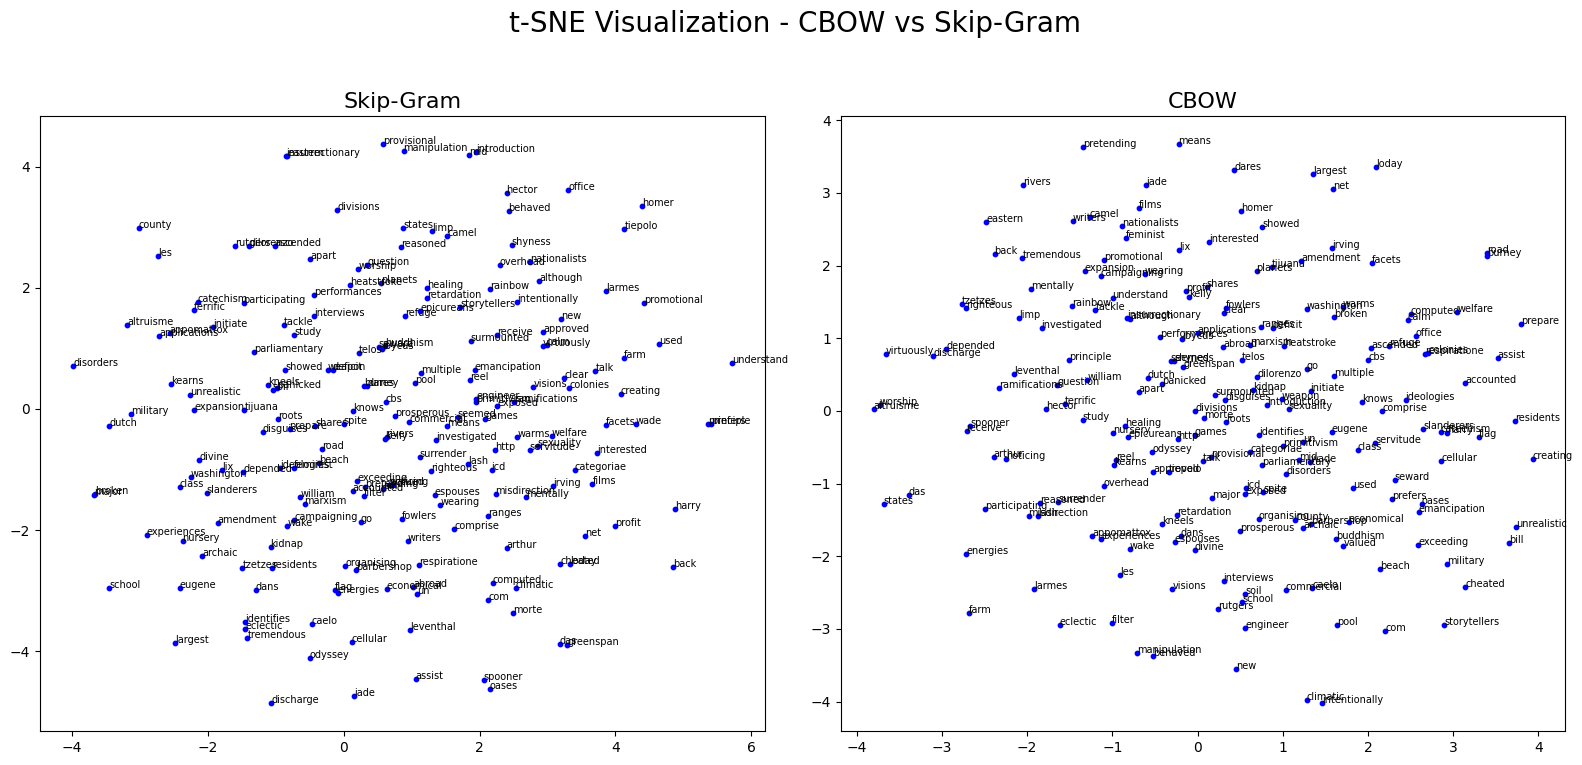

In [26]:
def tsne_plot(embedding_list: list, labels, model_names: list, title='t-SNE Visualization - CBOW vs Skip-Gram'):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(title, fontsize=20)

    for idx, (embeddings, name) in enumerate(zip(embedding_list, model_names)):
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        reduced = tsne.fit_transform(embeddings)

        ax = axes[idx]
        ax.scatter(reduced[:, 0], reduced[:, 1], s=10, color='blue')

        # Use the same label list for all plots
        for i, label in enumerate(labels):
            # Annotate
            ax.annotate(label, (reduced[i, 0], reduced[i, 1]), fontsize=7)

        ax.set_title(name, fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

tsne_plot([skipgram_subset, cbow_subset], vocab_subset, ['Skip-Gram', 'CBOW'])

In this example, the same 200 word sub-sample was visualized using t-SNE for both our CBOW and Skipgram embeddings. Words closer together are more similar in meaning. Below are some specific examples which can be seen in the graphs above, with an example of how these might be used together on a Wikipedia article

#### CBOW
- "accounted" - "heatstroke" (heatstroke accounted for 10% of deaths)
- "experiences" - "divine" (self-explanatory)
- "washington" - "farm" (George Washington grew up in a farm in Vermont)
- "application" - "approved" (also self-explanatory)
- "profit" - "welfare" (profit and welfare are both words used in macroeconomics discussions)

#### Skipgram
- "eugene" - "county" - "residents" (Eugene, a city with 176,000 residents, is the county seat of Lane County, Oregon)
- "http" - "net" (self-explanatory)
- "flag" - "filter" (these two words can be used interchangeably when talking about something like a system which has flags or filters for bad words, for example)
- "buddhism" - "worship" (also self-explanatory)
- "exceeding" - "commercial" (the commercial activity in the area was exceeding its resources)

# <font color= #bbc28d> **2. UMAP** </font>

UMAP is another algorithm used for dimension reduction based on manifold learning techniques and ideas from topological data analysis. It's a non-linear dimension reduction algorithm that seeks to **learn the structure of the data and find a low dimensional embedding that preserves the essential topological structure** of that manifold (lower-dimensional curved surface that resembles and preserves the characteristics of data stored in a high-dimensional space).

UMAP has 4 major hyperparameters:
- n_neighbors
    - Controls how UMAP balances local vs global structure in the data, by constraining the size of the local neighbourhood UMAP will look at when attempting to learn the manifold structure of the data. **Low values focus on local structures, large values focus on the bigger picture.**
- min_dist
    - Controls how tightly UMAP is allowed to pack points together. **Low values result in clumpier embeddings, large values prevent stacking and result in the preservation of the broader topological structure.** 
- n_components
    - Dimensions of the final reduction.
- metric
    - Controls **how distance is computed**. 

In [78]:
def umap_plot(embedding_list, labels, model_names, title='UMAP Projection - CBOW vs Skip-Gram'):
    # Create subplots for visualization
    fig = sp.make_subplots(rows=1, cols=2, subplot_titles=model_names)

    for idx, (embeddings, name) in enumerate(zip(embedding_list, model_names), start=1):
        # Initialize UMAP object
        umap_2d = UMAP(n_components=2, n_neighbors=2, min_dist=0.3, init='random', random_state=42, n_jobs=1)
        # Reduce dimensionality
        proj = umap_2d.fit_transform(embeddings)

        # Create dataframe with coordinates for each data point and their corresponding words
        df = pd.DataFrame({
            'x': proj[:, 0],
            'y': proj[:, 1],
            'word': labels
        })

        # Create scatter plot with text annotations
        scatter = go.Scatter(
            x=df['x'], y=df['y'],               # Data
            mode='markers+text',                # Show points and labels
            text=df['word'],                    # Words to be annotated
            textposition='top center', textfont=dict(size=9),         # Position and font size of the labels (words)
            hoverinfo='text',                   # Hovering shows the word
            showlegend=False,
            marker=dict(size=6, color='blue')
        )
        # Append the scatter plot to the subplot
        fig.add_trace(scatter, row=1, col=idx)

    # Update the layout
    fig.update_layout(
        height=600,
        width=1400,
        title=dict(text=title, x=0.5, xanchor='center', font=dict(size=20)),
        showlegend=False
    )

    fig.show()

For the UMAP dimensionality reduction, we chose the following hyperparameters:
- **n_neighbors:** 3
- **min_dist:** 0.1

Since we want to observe the specific topological structure of the words.

In [72]:
umap_plot([skipgram_subset, cbow_subset], vocab_subset, ['Skip-Gram', 'CBOW'])

#### Skipgram
- "dutch" - "bill" (probably talking about an influential bill proposed in the Netherlands)
- "colonies" - "farm" (a little bit self-explanatory)
- "servitude" - "ramifications" (probably referring to the implications servitude has)
- "initiates" - "participating" - "parliamentary" (words that may be commonly found together)
- "comercial" - "prosperous" (probably talking about a prosperous commerce)

#### CBOW
- "emancipation" - "buddhism" - "valued" (probably talking about details of the buddhist religion)
- "manipulation" - "archaich" - "parlamentary" (may refer to a critic to the government systems)
- "office" - "wellfare" (relation may be built upon the uses of the office)
- "shares" - "profit" (self-explanatory)
- "feminist" - "writers" - "promotional" (may refer to the rise of feminism)

# <font color= #bbc28d> **Bibliography** </font>

- Riva, M. (2025, February 13). _Word Embeddings: CBOW vs Skip-Gram_. Baeldung CS. https://www.baeldung.com/cs/word-embeddings-cbow-vs-skip-gram
- Van der Maaten, L., Hinton, G. (2008) *Visualizing Data using t-SNE*. **Journal of Machine Learning Research**. https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
- McInnes, L. (2018). _Basic UMAP Parameters_. UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. https://umap-learn.readthedocs.io/en/latest/parameters.html
- Plotly. (n.d.). _t-SNE and UMAP projections in Python_. Plotly. https://plotly.com/python/t-sne-and-umap-projections